# Trabalho prático - criação de modelo de ML - Airbnb

O presente trabalho é atividade constituinte do treinamento de Introdução à Ciência de Dados e consiste em:

"Elaborar um modelo que preveja o preço de locação do imóvel a partir dos demais atributos
- Variável alvo: Price da tabela calendar.csv. Notar que a cardinalidade do seu dado passa a ser a dessa tabela.
- Atributos de entrada: seja criativo. Inclusive está liberado buscar fontes externas de dados, como dados georeferenciados que estão na página de download dos arquivos ou qualquer outra informação útil.

CUIDADOS: A validação cruzada deve separar os imóveis em folds diferentes, ou seja, cuidado para não colocar dados de um mesmo imóvel da tabela calendar, em folds diferentes."

Foi selecionada a cidade de Toronto (da mesma forma que para o TP1-EDA) para a análise em referência.

# Importação de bibliotecas e listagem de arquivos anexos

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Importação de dados

In [ ]:
# Leitura de tabelas para dataframes homônimos
df_listings = pd.read_csv("../input/airbnbtoronto/listings.csv")
df_calendar = pd.read_csv("../input/airbnbtoronto/calendar.csv")
df_reviews = pd.read_csv("../input/airbnbtoronto/reviews.csv")

# Análise exploratória de dados

Os dados aqui exibidos, foram obtidos da página [Inside Airbnb](http://insideairbnb.com/get-the-data.html) para a cidade de [Toronto](https://pt.wikipedia.org/wiki/Toronto). Aanálise exporatória desses dados foi realizada no notebook [TP1-EDA](https://www.kaggle.com/thomasandarilho/tp1-eda) da qual serão replicados alguns gráficos. O primeiro destes é a distribuição dos preços ao longo dos meses.
## Preços constantes ao longo do ano
Desse gráfico é possível observar que,de forma geral, os preços se mantém constantes ao longo do ano, o que significa que as informações contidas na tabela "calendar.csv" contém pouca informação adicional. Por este motivo, a análise será restrita aos dados contidos na tabela "listings.csv", que já contém dados de preço. 

In [ ]:
# Remove vírgulas indicadoras de milhar da coluna "price"
df_calendar["price_numeric"] = df_calendar["price"].replace(to_replace = r",", value = "", regex = True)
# Remove primeiro caractere do preço ($) e depois converte para numerico
df_calendar["price_numeric"] = pd.to_numeric(df_calendar["price_numeric"].str.slice(start=1).replace(",",""))
# Cria nova coluna no dataframe calendario com datas no formato datetime
df_calendar["datetime"] = pd.to_datetime(df_calendar["date"])
# Cria  nova coluna com informação de més da hospedagem
df_calendar["month"] = pd.DatetimeIndex(df_calendar["datetime"]).month
# Cria gráfico com distribuição de preços ao longo dos meses
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = "month", y = "price_numeric", data = df_calendar, ax=ax, showfliers=False)

## Pouco turismo?
Essa característica pode representar uma atividade turística pouco relevante com relação ao total de imóveis da cidade, comportamento diferente de outras cidade, como o Rio de Janeiro, onde pode ser observada uma grande variação de preços ao longo do ano com picos em datas específicas, como carnaval.

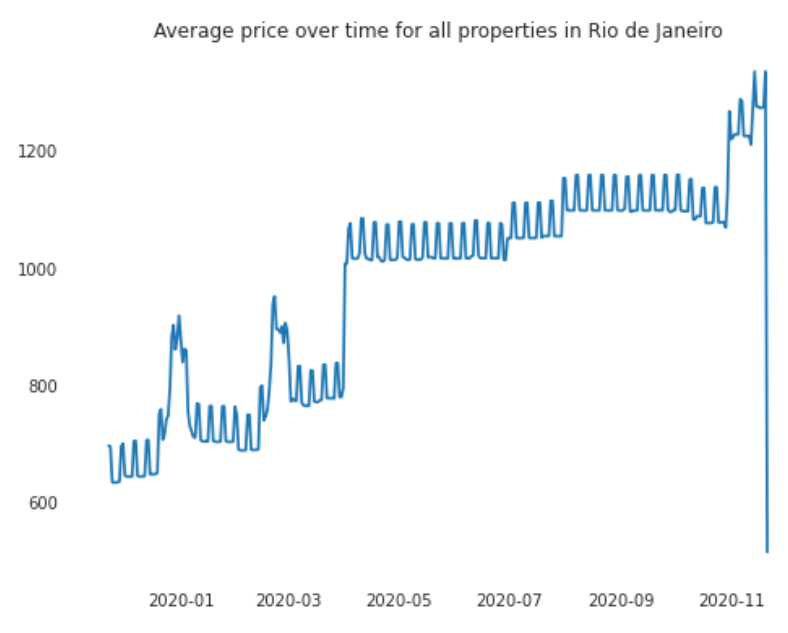

O gráfico em referência foi obtido do [Notebook com análise de preços da cidade do Rio de Janeiro](https://www.kaggle.com/vabatista/airbnb-and-real-state-eda-in-rio-de-janeiro)

Desse gráfico é possível observar que,de forma geral, os preços se mantém constantes ao longo do ano, o que significa que as informações contidas na tabela "calendar.csv" contém pouca informação adicional. Por este motivo, a análise será restrita aos dados contidos na tabela "listings.csv", que já contém dados de preço.

## Inflação?
Nesse caso específico, a curva crescente mostra efeito da alta taxa de aumento nos valores dos imóveis nos ultimos 12 meses no Brasil ([IGPM](https://portal.fgv.br/noticias/igpm-julho-2021)).

# Tratamento de dados


A seguir será realizado tratamento dos dados de preço e sua conversão de valor do tipo texto para numérico.

In [ ]:
# Remove vírgulas indicadoras de milhar da coluna "price"
df_listings["price_numeric"] = df_listings["price"].replace(to_replace = r",", value = "", regex = True)
# Remove primeiro caractere do preço ($) e depois converte para numerico
df_listings["price_numeric"] = pd.to_numeric(df_listings["price_numeric"].str.slice(start=1).replace(",",""))
# VIsualização de distribuição de frequencia dos preços
df_listings["price_numeric"].plot(kind = "hist")

Com o objetivo de mostrar a distribuição espacial dos preços, foi gerada uma visualização onde os valores mais próximos ou superiores a 300 dolares canadenses foram inclusos no gráfico nem uma tonalidade mais próxima do tom vermelho.

In [ ]:
#função para converter valor do aluguel até 300 em tom de vermelho hexadecimal
def valor_para_cor(valor):
    teto = 300
    if valor < teto:
        valor_normalizado = valor/teto
    else:
        valor_normalizado = 1
    valor_hexadecimal = hex(int(valor_normalizado*255))[2:]
    string_cor = "#" + valor_hexadecimal +"0000"
    return string_cor

In [ ]:
toronto_map = folium.Map(location=[43.720, -79.400], zoom_start = 10)

# Inserir marcadores com imóveis no mapa
for lat, lng, label, price in zip( df_listings["latitude"], df_listings["longitude"], df_listings["listing_url"], df_listings["price_numeric"]):
    folium.features.CircleMarker(
        [lat, lng],
        radius = 1, # define how big you want the circle markers to be
#        color = '#FF0000',
        color = valor_para_cor(price),
        fill = True,
        popup = label,
    ).add_to(toronto_map)

#toronto_map

Da visualização em referência é possível observar uma tendência de aumento de preços à medida em que nos aproximamos da região central da cidade, com tons mais intensos de vermelho.
A seguir, a o detalhamento das colunas da fonte de dados. É possível observar que nem todos os formatos de dados correspondem ao listado no dicionário, principalmente as colunas se encontram com tipo "object" (que no Pandas corresponde a texto).

In [ ]:
df_listings.info()

De forma a identificar variávieis correlacionadas entr e si, foi gerado um mapa de calor das correlações entre elas.

In [ ]:
# Gerado dataframe com correlações entre variáveis
corr = df_listings.corr()
# Definido tamanho do gráfico
plt.figure(figsize=(10,10))
# Gera gráfico de mapa de calor com base no dataframe de correlações
sns.heatmap(corr)

Nesse gráfico é possível observar correlação maior (tons mais claros) do custo unitário da diária com número máximo de hospedes, número de quarto e número de camas. Serão exploradas as correlações dessas variáveis entre si por meio de gráficos de dispersão e a distribuição de frequencia de cada variável será exibida na diagonal principal.

# Pycaret

A seguir, segue regressão realizada com base na [página do pycaret](https://pycaret.org/guide/), mais especificamente no [exemplo de regressão](https://github.com/pycaret/pycaret/blob/master/examples/PyCaret%202%20Regression.ipynb). Primeiramente será realizada a instalação do Pycaret.

In [ ]:
! pip install pycaret

In [ ]:
# check version
from pycaret.utils import version
version()

In [ ]:
## Preparação de dados
df_listings = pd.read_csv("../input/airbnbtoronto/listings.csv")
# Remove vírgulas indicadoras de milhar da coluna "price"
df_listings["price_numeric"] = df_listings["price"].replace(to_replace = r",", value = "", regex = True)
# Remove primeiro caractere do preço ($) e depois converte para numerico
df_listings["price_numeric"] = pd.to_numeric(df_listings["price_numeric"].str.slice(start=1).replace(",",""))
df_listings["host_since_datetime"] = pd.to_datetime(df_listings["host_since"])

df_listings_reduzido = df_listings[["host_response_rate",
                                    "host_is_superhost",
#                                    "host_since_datetime",
                                    "latitude",
                                    "longitude",
                                    "property_type",
                                    "accommodates",
                                    "bathrooms",
                                    "bedrooms",
                                    "beds",
                                    "price_numeric",
                                    ]]
df_listings_reduzido.head()

In [ ]:
df_listings_reduzido.info()

In [ ]:
from pycaret.regression import *
reg1 = setup(df_listings_reduzido,
             target ="price_numeric",
             session_id = 123,
             log_experiment = True,
             experiment_name = 'regressao1')

# Compare Baseline

In [ ]:
best_model = compare_models(fold=5)

In [ ]:
br = create_model("br")

In [ ]:
tuned_br = tune_model(br, n_iter=50, optimize = 'MAE')

In [ ]:
plot_model(tuned_br)

In [ ]:
plot_model(tuned_br, plot = "error")

In [ ]:
plot_model(tuned_br, plot = "feature")

In [ ]:
xgboost = create_model("xgboost")

In [ ]:
tuned_xgboost = tune_model(xgboost, n_iter=50, optimize = 'MAE')

In [ ]:
plot_model(tuned_xgboost)

In [ ]:
plot_model(tuned_xgboost, plot = "error")

In [ ]:
plot_model(tuned_xgboost, plot = "feature")

In [ ]:
interpret_model(tuned_xgboost)

In [ ]:
interpret_model(tuned_xgboost, plot = 'correlation')